In [245]:
import networkx as nx
from staticmap import StaticMap, CircleMarker, Line
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import math
from pprint import *
import warnings
warnings.filterwarnings('ignore')

In [246]:
#======we import the orders======#
df_orders = pd.read_csv('data\orders.csv', sep=';')

In [247]:
# import data from csv file
df_cities = pd.read_csv('data\cities_data_costs.csv')
norm_par = ['co2_per_unit', 'cost_per_unit']
df_norm = df_cities.copy()
for par in norm_par:
    df_norm[par] = (df_cities[par]-df_cities[par].min())/(df_cities[par].max()-df_cities[par].min())

In [248]:
def get_cost(emissions, cost, alpha):
    return alpha*emissions + (1-alpha)*cost

In [249]:
def get_cost_path(city_orig, city_dest, df_func):
    if(city_orig[2:] == city_dest[2:]):
        return 0
    pes = df_func[(df_func['city_from_name']==city_orig[2:]) & (df_func['city_to_name']==city_dest[2:])]
    if pes.empty:
        pes = df_func[(df_func['city_from_name']==city_dest[2:]) & (df_func['city_to_name']==city_orig[2:])]
    return pes['cost'].values[0]

In [250]:
def declare_costs_graph(G, ports, hubs, cities, df_func):
    for p in ports:
        for h in hubs:
            pes = get_cost_path(p, h, df_func)
            G.add_edge(p, h, cost=pes)
    for h in hubs:
        for c in cities:
            pes = get_cost_path(c, h, df_func)
            G.add_edge(h, c, cost=pes)

In [251]:
def get_min_cost_matrix(G, ports, cities, df_func):
    '''Matrix that stores the cost of minimum path of: [port][customer][extra hub]
    extra_hub = 0 -> no extra hub, extra_hub -> extra hub - 1'''
    M = np.zeros((len(ports), len(cities), len(cities)+1))
    for p in range(len(ports)):
        for c in range(len(cities)):
            M[p, c, 0] = nx.dijkstra_path_length(G, ports[p], cities[c], weight='cost')

    for p in range(len(ports)):
        for c in range(len(cities)):
            for h in range(1, len(cities)+1):
                new_path = get_cost_path(ports[p], cities[h-1], df_func) + get_cost_path(cities[h-1], cities[c], df_func)
                M[p, c, h] = min(M[p, c, 0], new_path)
    return M

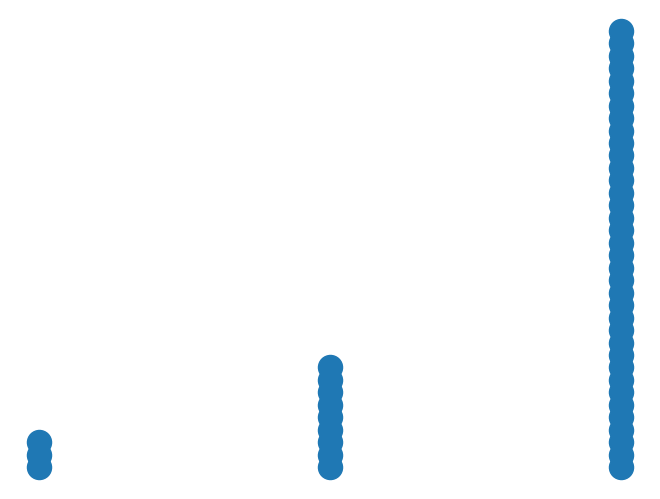

In [252]:
PORTS = ['Barcelona', 'Rotterdam', 'Athens']
HUBS = ['Hamburg', 'Lille', 'Warsaw', 'Zaragoza', 'Bratislava', 'Dusseldorf', 'Liege', 'Venlo', 'Rome']
CITIES  = df_cities['city_from_name'].unique()
PORTS = ['p-'+p for p in PORTS]
HUBS = ['h-'+h for h in HUBS]
CITIES = ['c-'+c for c in CITIES]

# create graph
G = nx.Graph()
for x in PORTS + HUBS + CITIES:
    G.add_node(x, bipartite= ['p-', 'h-', 'c-'].index(x[:2]))


nodes = G.nodes()
# for each of the parts create a set 
nodes_0  = set([n for n in nodes if  G.nodes[n]['bipartite']==0])
nodes_1  = set([n for n in nodes if  G.nodes[n]['bipartite']==1])
nodes_2  = set([n for n in nodes if  G.nodes[n]['bipartite']==2])

# set the location of the nodes for each set
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(nodes_0) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(nodes_1) ) # put nodes from Y at x=2
pos.update( (n, (3, i)) for i, n in enumerate(nodes_2) ) # put nodes from X at x=1
# draw graph
nx.draw(G, pos=pos)

In [253]:
def generate_matrices(alpha):
    # generates the matrices for each of the weights
    matrices = [] # list of matrixs for each weight class
    for weight in range(10):
        df_cities_weight = df_norm.iloc[weight::10,:]
        cost = [get_cost(df_cities_weight['co2_per_unit'].iloc[i], df_cities_weight['cost_per_unit'].iloc[i], alpha) for i in range(len(df_cities_weight))]
        df_cities_weight['cost'] = cost
        df_cities_weight = df_cities_weight.drop(columns=['co2_per_unit', 'cost_per_unit', 'city_from_coord', 'city_to_coord', 'weight_class', 'distance'])
        declare_costs_graph(G, PORTS, HUBS, CITIES, df_cities_weight)
        M = get_min_cost_matrix(G, PORTS, CITIES, df_cities_weight)
        matrices.append(M)
    return matrices

In [254]:
def get_freq_matrix(df_func):
    # Matrix that stores the frequency of  path: [weight][port][customer]
    F = np.zeros((10, len(PORTS), len(CITIES)))
    for w in range(10):
        for p in range(len(PORTS)):
            for c in range(len(CITIES)):
                F[w, p, c] = np.sum(df_func.loc[(df_func['weight_class']==w) & (df_func['origin_port']==PORTS[p][2:]) & (df_func['customer']==CITIES[c][2:])]['units'].values)
    return F

In [255]:
df_orders = pd.read_csv('data\dataframefinal.csv')
F = get_freq_matrix(df_orders)

In [302]:
# we ponderate the vector with the calclated frequencies
def ponderate_vector(matrices, F, alpha):
    pond_vect = []
    for extra_h in range(len(CITIES)+1):
        sum = 0
        for w in range(10):
            for p in range(len(PORTS)):
                for c in range(len(CITIES)):
                    sum += F[w, p, c]*matrices[w][p, c, extra_h]
        if not CITIES[extra_h-1][2:] in [h[2:] for h in HUBS]:
            pond_vect.append((alpha, sum, CITIES[extra_h-1][2:] if extra_h > 0 else 'No Extra Hub'))
    return pond_vect

In [303]:
def sort_and_save(pond_vect, alpha):
    pond_vect.sort()
    df = pd.DataFrame(pond_vect, columns=['alpha', 'cost', 'extra_hub'])
    existing_df = pd.read_csv('data/results_alpha.csv')
    if not alpha in existing_df['alpha'].unique():
        df.to_csv('data/results_alpha.csv', mode='a', index=False, header=False)

In [304]:
def show_pond_vector(pond_vect):
    # histogram of pond_vect
    plt.bar([x[2] for x in pond_vect], [x[1] for x in pond_vect])
    plt.xticks(rotation=90)
    offset = 100
    plt.ylim(pond_vect[0][1] - offset, pond_vect[-1][1] + offset)
    plt.show()

In [305]:
def generate_hub_list(alpha, show = False):
    matrices = generate_matrices(alpha)
    pond_vect = ponderate_vector(matrices, F, alpha)
    sort_and_save(pond_vect, alpha)
    if show:
        show_pond_vector(pond_vect)

In [306]:
def better_extra_hub(alpha, port = False):
    '''returns the better extra hub for a given alpha'''
    df = pd.read_csv('data/results_alpha.csv')
    df = df.loc[df['alpha']==alpha]
    for i, x in df.iterrows():
        if port:
            return x['extra_hub']
        else:
            if not x['extra_hub'] in [p[2:] for p in PORTS]:
                return x['extra_hub']

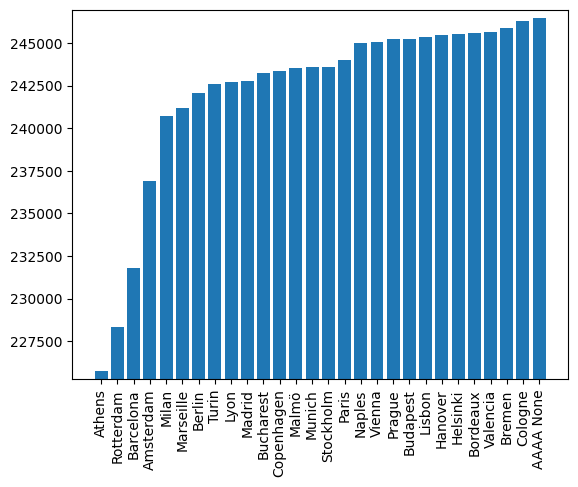

With alpha 0 better extra hub city: Amsterdam


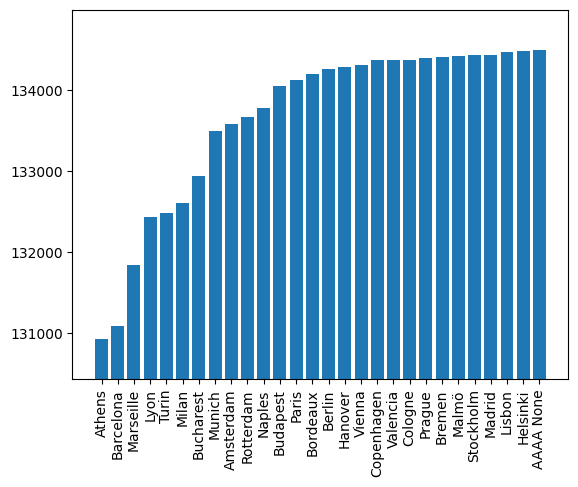

With alpha 1 better extra hub city: Marseille


In [261]:
for alpha in [0, 1]:
    generate_hub_list(alpha, True)
    print('With alpha', alpha, 'better extra hub city:',better_extra_hub(alpha))

In [310]:
pond_vects = []
for alpha in [0, 1]:
    matrices = generate_matrices(alpha)
    pond_vect = list(ponderate_vector(matrices, F, alpha))
    sort_and_save(pond_vect, alpha)
    pond_vects.append(pond_vect)

In [311]:
# denormalize the data
MULTIPLIER = 1/10**6
pond_vect0 = [(x[0], (without_COST - x[1]*(df_cities['cost_per_unit'].max() - df_cities['cost_per_unit'].min()) + df_cities['cost_per_unit'].min())*MULTIPLIER, x[2]) for x in pond_vects[0]]
pond_vect1 = [(x[0], (without_EMISSIONS - x[1]*(df_cities['co2_per_unit'].max() - df_cities['co2_per_unit'].min()) + df_cities['co2_per_unit'].min())*MULTIPLIER, x[2]) for x in pond_vects[1]]
pond_vect0.sort()
pond_vect1.sort()

In [321]:
def show_pond_vector(pond_vect, y_label):
    # histogram of pond_vect
    plt.bar([x[2] for x in pond_vect], [x[1] for x in pond_vect])
    plt.xticks(rotation=90)
    offset = 0
    plt.ylim(pond_vect[0][1] - offset, pond_vect[-1][1] + offset+2)
    # the y-axis is in millions of euros
    plt.ylabel(y_label)
    # change the graph color to purple
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['purple'])
    plt.show()

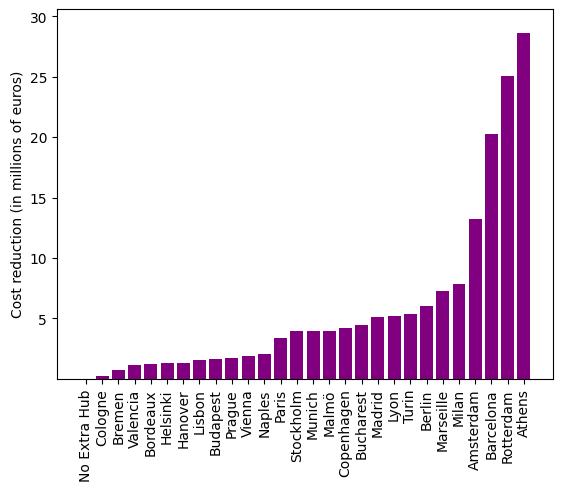

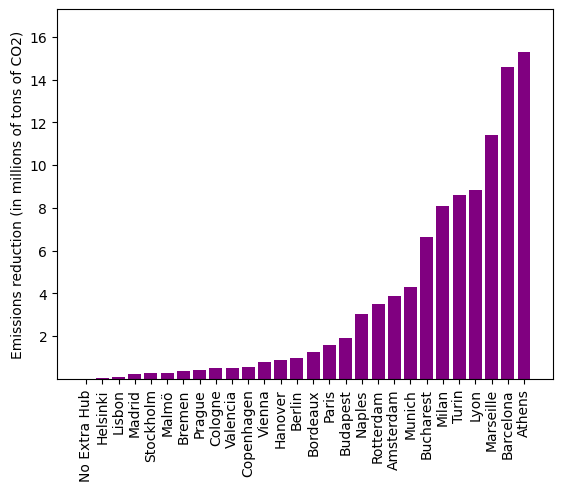

In [323]:
show_pond_vector(pond_vect0, 'Cost reduction (in millions of euros)')
show_pond_vector(pond_vect1, 'Emissions reduction (in millions of tons of CO2)')

In [265]:
calculated_df = pd.read_csv('data/results_alpha.csv')
# para Amsterdam (alpha = 0, main objective is reduce cost)
normalized_cost = calculated_df.loc[(calculated_df['alpha']==0) & (calculated_df['extra_hub']=='Amsterdam')]['cost'].values[0]
original_cost = normalized_cost*(df_cities['cost_per_unit'].max() - df_cities['cost_per_unit'].min()) + df_cities['cost_per_unit'].min()
print(f"COST with Amsterdam hub: {original_cost:_.1f}")

# para Marseille (alpha = 1, main objective is reduce co2)
normalized_cost = calculated_df.loc[(calculated_df['alpha']==1) & (calculated_df['extra_hub']=='Marseille')]['cost'].values[0]
original_cost = normalized_cost*(df_cities['co2_per_unit'].max() - df_cities['co2_per_unit'].min()) + df_cities['co2_per_unit'].min()
print(f"co2 EMISSION with Marseille hub {original_cost:_.1f}")

COST with Amsterdam hub: 327_413_735.4
co2 EMISSION with Marseille hub 566_732_476.3


In [266]:
matrices0 = generate_matrices(0)
matrices1 = generate_matrices(1)

In [267]:
pv0 = ponderate_vector(matrices0, F, 0)
pv1 = ponderate_vector(matrices1, F, 1)
print(pv0[3])

(0, 241166.73943432677, 'Marseille')


In [324]:
normalized_cost = pv0[0][1]
without_COST = normalized_cost*(df_cities['cost_per_unit'].max() - df_cities['cost_per_unit'].min()) + df_cities['cost_per_unit'].min()
print(f"COST without adding hubs: {without_COST:_.1f}")
normalized_cost = pv0[10][1]
original_cost = normalized_cost*(df_cities['cost_per_unit'].max() - df_cities['cost_per_unit'].min()) + df_cities['cost_per_unit'].min()
print(f"COST with Amsterdam hub: {original_cost:_.1f}")

normalized_cost = pv1[0][1]
without_EMISSIONS = normalized_cost*(df_cities['co2_per_unit'].max() - df_cities['co2_per_unit'].min()) + df_cities['co2_per_unit'].min()
print(f"EMISSIONS without adding hubs: {without_EMISSIONS:_.1f}")
normalized_cost = pv1[3][1]
original_cost = normalized_cost*(df_cities['co2_per_unit'].max() - df_cities['co2_per_unit'].min()) + df_cities['co2_per_unit'].min()
print(f"EMISSIONS with Amsterdam hub: {original_cost:_.1f}")

COST without adding hubs: 340_613_818.2
COST with Amsterdam hub: 327_413_735.4
EMISSIONS without adding hubs: 578_136_244.7
EMISSIONS with Amsterdam hub: 566_732_476.3


Visualización Gráfica del Grafo

In [269]:
df_cities = pd.read_csv('data\cities_data_costs.csv')
df_cities.head()
city_coords = {}
for i, x in df_cities.iterrows():
    temp = x['city_from_coord'].replace('(','').replace(')','').split(',')
    city_coords[x['city_from_name']] = (float(temp[1]), float(temp[0]))
    temp = x['city_to_coord'].replace('(','').replace(')','').split(',')
    city_coords[x['city_to_name']] = (float(temp[1]), float(temp[0]))
print(city_coords.keys())

dict_keys(['Dusseldorf', 'Zaragoza', 'Venlo', 'Bratislava', 'Hamburg', 'Rome', 'Lille', 'Liege', 'Warsaw', 'Paris', 'Lyon', 'Marseille', 'Bordeaux', 'Milan', 'Berlin', 'Madrid', 'Vienna', 'Munich', 'Amsterdam', 'Stockholm', 'Copenhagen', 'Barcelona', 'Cologne', 'Athens', 'Bucharest', 'Budapest', 'Naples', 'Lisbon', 'Turin', 'Hanover', 'Malmö', 'Helsinki', 'Prague', 'Valencia', 'Bremen', 'Porto', 'Rotterdam'])


In [270]:
freq = np.zeros((len(PORTS), len(CITIES)))
for w in range(10):
    freq += F[w]
freq /= np.amax(freq)
print(freq)

[[0.         0.         0.         0.         0.         0.13098329
  0.         0.         0.         0.22257829 0.17714587 0.12996917
  0.0511926  0.33311699 0.33753854 0.31064417 0.24071069 0.20894856
  0.17840337 0.17264319 0.16915463 0.1415301  0.14027259 0.12104495
  0.11763751 0.08802531 0.09528639 0.06563362 0.07050138 0.0774785
  0.07549083 0.05131429 0.05224728 0.05703391 0.05220672 0.        ]
 [0.         0.         0.         0.         0.         0.38382281
  0.         0.         0.         0.68148629 0.50847801 0.40463248
  0.17394126 0.99882362 1.         0.94158689 0.72274055 0.63698686
  0.57463897 0.49886419 0.51582022 0.45817784 0.41254259 0.32873601
  0.34139218 0.27782736 0.27072854 0.22237547 0.22387636 0.22525556
  0.21552004 0.15958137 0.17211585 0.17909297 0.1683839  0.        ]
 [0.         0.         0.         0.         0.         0.17807886
  0.         0.         0.         0.29287685 0.2042025  0.17146682
  0.06766185 0.41736979 0.44296609 0.42166964 0

HUB: AMSTERDAM

In [271]:
PORTS = ['Barcelona', 'Rotterdam', 'Athens']
HUBS = ['Hamburg', 'Lille', 'Warsaw', 'Zaragoza', 'Bratislava', 'Dusseldorf', 'Liege', 'Venlo', 'Rome']
CITIES  = df_cities['city_from_name'].unique()
PORTS = ['p-'+p for p in PORTS]
HUBS = ['h-'+h for h in HUBS]
CITIES = ['c-'+c for c in CITIES]

HUBS.append('h-Amsterdam')

G_tri = nx.Graph()
for x in CITIES + PORTS + HUBS:
    G_tri.add_node(x, pos=city_coords[x[2:]], type= x[:1])

WEIGHT = 5
alpha = 0
df_cities_weight = df_norm.iloc[WEIGHT::10,:]
cost = [get_cost(df_cities_weight['co2_per_unit'].iloc[i], df_cities_weight['cost_per_unit'].iloc[i], alpha) for i in range(len(df_cities_weight))]
df_cities_weight['cost'] = cost
declare_costs_graph(G_tri, PORTS, HUBS, CITIES, df_cities_weight)

# create graph
G = nx.Graph()
for x in CITIES + PORTS + HUBS:
    G.add_node(x, pos=city_coords[x[2:]], type= x[:1])

for p in PORTS:
    for h in HUBS:
        for c in CITIES:
            G.add_edge(p, h, pes = 0.0)
            G.add_edge(h, c, pes = 0.0)

for i, p in enumerate(PORTS):
        for j, c in enumerate(CITIES):
            h = nx.dijkstra_path(G_tri, p, c, weight='cost')[1]
            G[p][h]['pes'] +=  freq[i][j]
            G[h][c]['pes'] += freq[i][j]

In [272]:
SIZE_X = 2000
SIZE_Y = 2000
PADDING = 10

map= StaticMap(
    SIZE_X, SIZE_Y, padding_x=PADDING, padding_y=PADDING,)

# we iterate through the edges
for node1, node2, data in G.edges(data=True):
    # we get the coordinates of the nodes
    x1, y1 = G.nodes[node1]['pos']
    x2, y2 = G.nodes[node2]['pos']
    color = '#d64747' if 'h-Amsterdam' in [node1, node2] else '#666463'
    if ['p-Rotterdam','h-Amsterdam'] == [node1, node2]:
        map.add_line(Line(((x1, y1), (x2, y2)), color, int(data['pes']*7)))
    else:
        map.add_line(Line(((x1, y1), (x2, y2)), color, int(data['pes']*10)))
color_type = {'p':'#003785', 'h':'#851d1d', 'c':'#377d34'}
size_type = {'p':25, 'h':15, 'c':12}

for u, d in G.nodes(data=True):
    if (u == 'h-Amsterdam'):
        map.add_marker(CircleMarker(d['pos'], "#4f0a0a", 25))
    else:
        map.add_marker(CircleMarker(d['pos'], color_type[d['type']], size_type[d['type']]))

image = map.render()
image.save('data/Amsterdam-hub.png')

HUB: MARSEILLE:

In [273]:
PORTS = ['Barcelona', 'Rotterdam', 'Athens']
HUBS = ['Hamburg', 'Lille', 'Warsaw', 'Zaragoza', 'Bratislava', 'Dusseldorf', 'Liege', 'Venlo', 'Rome']
CITIES  = df_cities['city_from_name'].unique()
PORTS = ['p-'+p for p in PORTS]
HUBS = ['h-'+h for h in HUBS]
CITIES = ['c-'+c for c in CITIES]

HUBS.append('h-Marseille')

G_tri = nx.Graph()
for x in CITIES + PORTS + HUBS:
    G_tri.add_node(x, pos=city_coords[x[2:]], type= x[:1])

WEIGHT = 5
alpha = 1
df_cities_weight = df_norm.iloc[WEIGHT::10,:]
cost = [get_cost(df_cities_weight['co2_per_unit'].iloc[i], df_cities_weight['cost_per_unit'].iloc[i], alpha) for i in range(len(df_cities_weight))]
df_cities_weight['cost'] = cost
declare_costs_graph(G_tri, PORTS, HUBS, CITIES, df_cities_weight)

# create graph
G = nx.Graph()
for x in CITIES + PORTS + HUBS:
    G.add_node(x, pos=city_coords[x[2:]], type= x[:1])
    
for p in PORTS:
    for h in HUBS:
        for c in CITIES:
            G.add_edge(p, h, pes = 0.0)
            G.add_edge(h, c, pes = 0.0)

for i, p in enumerate(PORTS):
        for j, c in enumerate(CITIES):
            h = nx.dijkstra_path(G_tri, p, c, weight='cost')[1]
            G[p][h]['pes'] +=  freq[i][j]
            G[h][c]['pes'] += freq[i][j]

In [274]:
SIZE_X = 2000
SIZE_Y = 2000
PADDING = 10

map= StaticMap(
    SIZE_X, SIZE_Y, padding_x=PADDING, padding_y=PADDING,)

# we iterate through the edges
for node1, node2, data in G.edges(data=True):
    # we get the coordinates of the nodes
    x1, y1 = G.nodes[node1]['pos']
    x2, y2 = G.nodes[node2]['pos']
    color = '#d64747' if 'h-Marseille' in [node1, node2] else '#666463'
    map.add_line(Line(((x1, y1), (x2, y2)), color, int(data['pes']*10)))
color_type = {'p':'#003785', 'h':'#851d1d', 'c':'#377d34'}
size_type = {'p':25, 'h':15, 'c':12}

for u, d in G.nodes(data=True):
    if (u == 'h-Marseille'):
        map.add_marker(CircleMarker(d['pos'], "#4f0a0a", 25))
    else:
        map.add_marker(CircleMarker(d['pos'], color_type[d['type']], size_type[d['type']]))

image = map.render()
image.save('data/Marseille-hub.png')

NO EXTRA HUBS:

In [275]:
PORTS = ['Barcelona', 'Rotterdam', 'Athens']
HUBS = ['Hamburg', 'Lille', 'Warsaw', 'Zaragoza', 'Bratislava', 'Dusseldorf', 'Liege', 'Venlo', 'Rome']
CITIES  = df_cities['city_from_name'].unique()
PORTS = ['p-'+p for p in PORTS]
HUBS = ['h-'+h for h in HUBS]
CITIES = ['c-'+c for c in CITIES]

G_tri = nx.Graph()
for x in CITIES + PORTS + HUBS:
    G_tri.add_node(x, pos=city_coords[x[2:]], type= x[:1])

WEIGHT = 5
alpha = 1
df_cities_weight = df_norm.iloc[WEIGHT::10,:]
cost = [get_cost(df_cities_weight['co2_per_unit'].iloc[i], df_cities_weight['cost_per_unit'].iloc[i], alpha) for i in range(len(df_cities_weight))]
df_cities_weight['cost'] = cost
declare_costs_graph(G_tri, PORTS, HUBS, CITIES, df_cities_weight)

# create graph
G = nx.Graph()
for x in CITIES + PORTS + HUBS:
    G.add_node(x, pos=city_coords[x[2:]], type= x[:1])

for p in PORTS:
    for h in HUBS:
        for c in CITIES:
            G.add_edge(p, h, pes = 0.0)
            G.add_edge(h, c, pes = 0.0)

for i, p in enumerate(PORTS):
        for j, c in enumerate(CITIES):
            h = nx.dijkstra_path(G_tri, p, c, weight='cost')[1]
            G[p][h]['pes'] += freq[i][j]
            G[h][c]['pes'] += freq[i][j]

In [276]:
SIZE_X = 2000
SIZE_Y = 2000
PADDING = 10

map= StaticMap(
    SIZE_X, SIZE_Y, padding_x=PADDING, padding_y=PADDING,)

# we iterate through the edges
for node1, node2, data in G.edges(data=True):
    # we get the coordinates of the nodes
    x1, y1 = G.nodes[node1]['pos']
    x2, y2 = G.nodes[node2]['pos']
    color = '#d64747' if 'h-Amsterdam' in [node1, node2] else '#666463'
    map.add_line(Line(((x1, y1), (x2, y2)), color, int(data['pes']*10)))
color_type = {'p':'#003785', 'h':'#851d1d', 'c':'#377d34'}
size_type = {'p':25, 'h':15, 'c':12}

for u, d in G.nodes(data=True):
    map.add_marker(CircleMarker(d['pos'], color_type[d['type']], size_type[d['type']]))

image = map.render()
image.save(f'data/No-extra-hub-alpha{alpha}.png')